# Project Paper
### Here is the link to the research paper for this dataset
### https://jivasquez.files.wordpress.com/2019/03/rp_cactus_recognition_elsa-1.pdf

# Import Dependencies
### Load in the libraries that you will need

In [1]:
#-------Import Dependencies-------#
%matplotlib inline
import pandas as pd
import os,shutil,math,scipy,cv2
import numpy as np
import matplotlib.pyplot as plt
import random as rn


from sklearn.utils import shuffle
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix,roc_curve,auc

from PIL import Image
from PIL import Image as pil_image
from PIL import ImageDraw

from time import time
from glob import glob
from tqdm import tqdm
from skimage.io import imread
from IPython.display import SVG

from scipy import misc,ndimage
from scipy.ndimage.interpolation import zoom
from scipy.ndimage import imread


from keras import backend as K
from keras.utils.np_utils import to_categorical
from keras import layers
from keras.preprocessing.image import save_img
from keras.utils.vis_utils import model_to_dot
from keras.applications.vgg16 import VGG16,preprocess_input
from keras.applications.xception import Xception
from keras.applications.nasnet import NASNetMobile
from keras.models import Sequential,Input,Model
from keras.layers import Dense,Flatten,Dropout,Concatenate,GlobalAveragePooling2D,Lambda,ZeroPadding2D
from keras.layers import SeparableConv2D,BatchNormalization,MaxPooling2D,Conv2D
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam,SGD
from keras.utils.vis_utils import plot_model
from keras.callbacks import ModelCheckpoint,EarlyStopping,TensorBoard,CSVLogger,ReduceLROnPlateau,LearningRateScheduler

Using TensorFlow backend.


# Custom Function
### function for visualizing training results

In [2]:
def show_final_history(history):
    fig, ax = plt.subplots(1, 2, figsize=(15,5))
    ax[0].set_title('loss')
    ax[0].plot(history.epoch, history.history["loss"], label="Train loss")
    ax[0].plot(history.epoch, history.history["val_loss"], label="Validation loss")
    ax[1].set_title('acc')
    ax[1].plot(history.epoch, history.history["acc"], label="Train acc")
    ax[1].plot(history.epoch, history.history["val_acc"], label="Validation acc")
    ax[0].legend()
    ax[1].legend()

# Image Preprocessing
### Thank to Keras ImageDataGenerator for image preprocessing and data augmentation

In [3]:
augs_gen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True)  

train_gen = augs_gen.flow_from_directory(
    '../input/training_set/training_set',
    target_size = (32,32),
    batch_size=32,
    shuffle=True,
    class_mode = 'binary'
)

test_gen = augs_gen.flow_from_directory(
    '../input/validation_set/validation_set/',
    target_size=(32,32),
    batch_size=32,
    shuffle=False,
    class_mode = 'binary'
)

Found 17500 images belonging to 2 classes.
Found 4000 images belonging to 2 classes.


# Model
### Here we create our model. I create the seperate conv block because it makes tweaking the model easier

In [4]:
model = Sequential()
model.add(Conv2D(6, kernel_size=(5,5),activation='relu',input_shape=(32,32,3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=2,strides=2))
model.add(Conv2D(16,kernel_size=5,strides=1,activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=2,strides=2))
model.add(Flatten())
model.add(Dense(120,activation='relu'))
model.add(Dense(84,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1,activation='sigmoid'))
model.summary()


SVG(model_to_dot(model).create(prog='dot', format='svg'))
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 6)         456       
_________________________________________________________________
batch_normalization_1 (Batch (None, 28, 28, 6)         24        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 6)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 10, 16)        2416      
_________________________________________________________________
batch_normalization_2 (Batch (None, 10, 10, 16)        64        
_________________________________________________________________
max_pooling2d_2 (MaxP

# Callbacks
### Here we use Keras callbacks to monitor how the training is going and adjust the training accordingly

In [5]:
#-------Callbacks-------------#
best_model_weights = './base.model'
checkpoint = ModelCheckpoint(
    best_model_weights,
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    mode='min',
    save_weights_only=False,
    period=1
)
earlystop = EarlyStopping(
    monitor='val_loss',
    min_delta=0.001,
    patience=10,
    verbose=1,
    mode='auto'
)
tensorboard = TensorBoard(
    log_dir = './logs',
    histogram_freq=0,
    batch_size=16,
    write_graph=True,
    write_grads=True,
    write_images=False,
)

csvlogger = CSVLogger(
    filename= "training_csv.log",
    separator = ",",
    append = False
)

#lrsched = LearningRateScheduler(step_decay,verbose=1)

reduce = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    verbose=1, 
    mode='auto',
    cooldown=1 
)

callbacks = [checkpoint,tensorboard,csvlogger,reduce]

# Train The Model
### Here we train the model with our generators

In [6]:
opt = SGD(lr=2e-4,momentum=0.99)
opt1 = Adam(lr=1e-2)

model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)
    
history = model.fit_generator(
    train_gen, 
    validation_data = test_gen,
    validation_steps = 75,
    steps_per_epoch  = 75, 
    epochs = 75,
    verbose = 1,
    callbacks=callbacks
)

Instructions for updating:
Use tf.cast instead.
Epoch 1/75
75/75 [==============================] - 12s 163ms/step - loss: 0.2687 - acc: 0.8975 - val_loss: 0.0119 - val_acc: 0.9962

Epoch 00001: val_loss improved from inf to 0.01188, saving model to ./base.model
Epoch 2/75
75/75 [==============================] - 10s 133ms/step - loss: 0.1944 - acc: 0.9204 - val_loss: 0.5291 - val_acc: 0.7446

Epoch 00002: val_loss did not improve from 0.01188
Epoch 3/75
75/75 [==============================] - 10s 131ms/step - loss: 0.1613 - acc: 0.9342 - val_loss: 0.1968 - val_acc: 0.9163

Epoch 00003: val_loss did not improve from 0.01188
Epoch 4/75
75/75 [==============================] - 9s 126ms/step - loss: 0.1703 - acc: 0.9358 - val_loss: 0.4650 - val_acc: 0.8125

Epoch 00004: val_loss did not improve from 0.01188
Epoch 5/75
75/75 [==============================] - 10s 127ms/step - loss: 0.1551 - acc: 0.9454 - val_loss: 0.2198 - val_acc: 0.9113

Epoch 00005: val_loss did not improve from 0.0118

# Evaluation
### Here we visualize the training, load the the best weights from the model, evaluate the model, and save the weights

Model Test Loss: 0.209590806529377
Model Test Accuracy: 0.9290625
Weights Saved


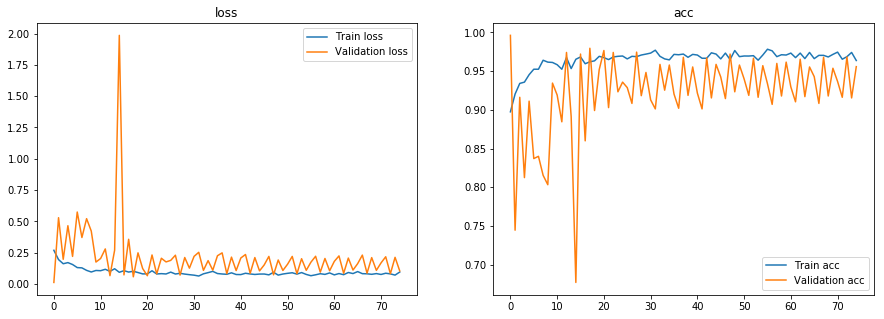

In [7]:
show_final_history(history)
model.load_weights(best_model_weights)
model_eval = model.evaluate_generator(test_gen,steps=100)
print("Model Test Loss:",model_eval[0])
print("Model Test Accuracy:",model_eval[1])

model_json = model.to_json()
with open("model.json","w") as json_file:
    json_file.write(model_json)
    
model.save("model.h5")
print("Weights Saved")

# TensorBoard
### Here is a script that will give you a url to view your model's training results.

In [8]:
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip ngrok-stable-linux-amd64.zip
LOG_DIR = './logs' # Here you have to put your log directory
get_ipython().system_raw(
    'tensorboard --logdir {} --host 0.0.0.0 --port 8080 &'
    .format(LOG_DIR)
)
get_ipython().system_raw('./ngrok http 8080 &')
! curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

--2019-03-24 02:42:58--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 52.71.139.107, 35.173.3.255, 52.203.102.189, ...
Connecting to bin.equinox.io (bin.equinox.io)|52.71.139.107|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13584026 (13M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip’

ngrok-stable-linux- 100%[===================>]  12.95M  35.0MB/s    in 0.4s    

2019-03-24 02:42:58 (35.0 MB/s) - ‘ngrok-stable-linux-amd64.zip’ saved [13584026/13584026]

Archive:  ngrok-stable-linux-amd64.zip
  inflating: ngrok                   
http://3ccc7201.ngrok.io
